In [39]:
import pandas as pd
import numpy as np
from itertools import groupby, permutations
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_colwidth = None
pd.options.display.max_rows = 69

In [2]:
CARDS = [
    'e1', 'e2', 'e3', 'e4', 'e5',
    'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 
    'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 
    'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 
    'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13', 'b14', 
    'm1', 'm2',
    'p1', 'p2', 'p3', 'p4', 'p5',
#     't1',
    'k1',
]
COLOR_SUITS = ['r','y','g','b']
SUIT_RANKS = {
    'e': 0,
    'r': 1, 'y': 1, 'g': 1,
    'b': 2,
    'p': 3, 'm': 3, 'k': 3,
}
WINNING_FACE_SUIT = {
    'k': 'k',
    'p': 'p',
    'm': 'm',
    'km': 'm',
    'kp': 'k',
    'mp': 'p',
    'kmp': 'm',
}
CARD_CLASSNAMES = [
    'escape',
    'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','c13','c14',
    'b1','b2','b3','b4','b5','b6','b7','b8','b9','b10','b11','b12','b13','b14',
    'mermaid',
    'pirate',
    'king',
]

def get_card_classname(card):
    suit, num = card[0], card[1:]
    if suit == 'b':
        return card
    if suit in COLOR_SUITS:
        return 'c'+num
    if suit == 'e':
        return 'escape'
    if suit == 'm':
        return 'mermaid'
    if suit == 'p':
        return 'pirate'
    if suit == 'k':
        return 'king'

def get_lead_suit(cards: "Card[]"):
    for card in cards:
        assert(card in CARDS)
        if card[0] == 'e':
            continue
        if card[0] in COLOR_SUITS:
            return card[0]
        return None

def get_winner_index(cards):
    assert(len(cards) > 0)
    winning = []
    winning_rank = 0
    for i, card in enumerate(cards):
        suit, num = card[0], int(card[1:])
        rank = SUIT_RANKS[suit]
        if rank < winning_rank:
            continue
        elif rank == winning_rank:
            winning.append((i, suit, num))
        elif rank > winning_rank:
            winning_rank = rank
            winning = [(i, suit, num)]
    # Single card in top rank or only escape cards
    if len(winning) == 1 or winning_rank == 0:
        return winning[0][0]
    # Top rank is colored cards (the only rank where lead suit is important)
    if winning_rank == 1:
        winning_index, lead_suit, winning_num = winning[0]
        for i, suit, num in winning[1:]:
            if suit == lead_suit and num > winning_num:
                winning_index = i
                winning_num = num
        return winning_index
    # Top rank is black color - just use highest number
    if winning_rank == 2:
        winning_index, _, winning_num = winning[0]
        for i, suit, num in winning[1:]:
            if num > winning_num:
                winning_index = i
                winning_num = num
        return winning_index
    # Top rank is a face card - look up winning suit based on suits present
    if winning_rank == 3:
        suits = ''.join(sorted({play[1] for play in winning}))
        winning_suit = WINNING_FACE_SUIT[suits]
        for i, suit, num in winning:
            if suit == winning_suit:
                return i
        

get_winner_index_tests = '''
e1 e2 e3 0
e1 y4 r5 1
r1 y9 r2 2
e1 r9 b1 2
e1 r9 b1 p1 k1 4
p2 k1 m1 p1 2
b9 p2 m1 p3 1
'''.strip().split('\n')
for test in get_winner_index_tests:
    test = test.split(' ')
    expected = int(test[-1])
    actual = get_winner_index(test[:-1])
    assert expected == actual, f'expected {test[:-1]} => {expected}, got {actual}'

In [5]:
# with open('plays.tsv','w') as f:
#     for num_players in range(2,5):
#         print('num_players',num_players)
#         for trick in permutations(CARDS, num_players):
#             winner = get_winner_index(trick)
#             for turn, card in enumerate(trick):
#                 f.write('\t'.join([get_card_classname(card), str(num_players), str(turn), str(winner == turn)])+'\n')

num_players 2
num_players 3
num_players 4


In [9]:
df = pd.read_csv('plays.tsv', sep='\t', names=['card','num_players','turn','won'], engine='c')
df['count'] = 1

In [13]:
df1 = df.groupby(['turn','won'])['count'].sum().sort_values(ascending=False).unstack()
df1['win_rate'] = df1[True] / df1.sum(axis=1)
df1

won,False,True,win_rate
turn,,,
0,14198577,6868503,0.326030
1,16057039,5010041,0.237814
2,16371332,4691056,0.222722
3,16250544,4497480,0.216767


In [28]:
df2 = df.groupby(['card','num_players','won'])['count'].sum().unstack().fillna(0)
df3 = (df2[True] / df2.sum(axis=1)).unstack().loc[CARD_CLASSNAMES,:]
df3

num_players,2,3,4
card,,,
escape,0.029412,0.000878,0.000020
c1,0.279412,0.090430,0.031906
c2,0.294118,0.100819,0.037739
c3,0.308824,0.111648,0.044091
c4,0.323529,0.122915,0.050982
c5,0.338235,0.134621,0.058431
c6,0.352941,0.146766,0.066459
c7,0.367647,0.159350,0.075086
c8,0.382353,0.172373,0.084331


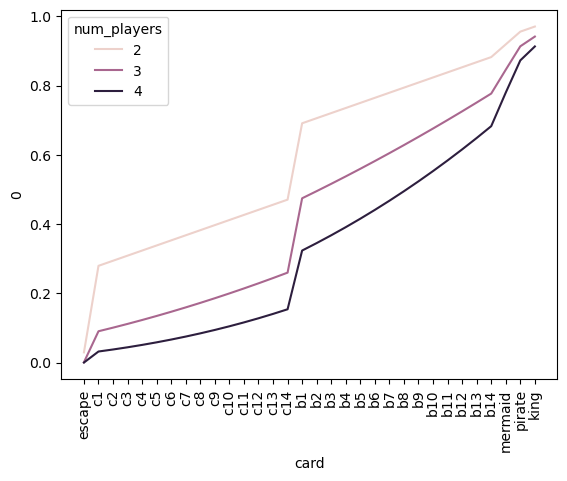

In [52]:
ax = sns.lineplot(data=df3.stack().reset_index(), x='card', y=0, hue='num_players')
plt.xticks(rotation=90)
plt.show()

In [53]:
df4 = df[df.turn == 0].groupby(['card','num_players','won'])['count'].sum().unstack().fillna(0)
df5 = (df4[True] / df4.sum(axis=1)).unstack().loc[CARD_CLASSNAMES,:]
df5

num_players,2,3,4
card,,,
escape,0.058824,0.002634,0.000080
c1,0.485294,0.231782,0.108867
c2,0.500000,0.246269,0.119403
c3,0.514706,0.261194,0.130597
c4,0.529412,0.276558,0.142469
c5,0.544118,0.292362,0.155040
c6,0.558824,0.308604,0.168329
c7,0.573529,0.325285,0.182357
c8,0.588235,0.342406,0.197143


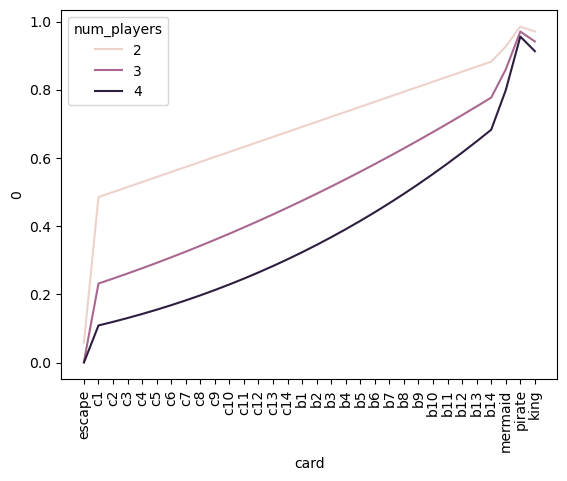

In [54]:
ax = sns.lineplot(data=df5.stack().reset_index(), x='card', y=0, hue='num_players')
plt.xticks(rotation=90)
plt.show()